## Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# lib manipulation data
import pandas as pd

# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *
from C05_model_evaluate import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Akuisisi Data

In [3]:
# load dataset
dataset = data_hotspot()
print(dataset.tail())

      acq_date  hotspot
271 2023-08-31      186
272 2023-09-30     2247
273 2023-10-31     3200
274 2023-11-30      390
275 2023-12-31       42


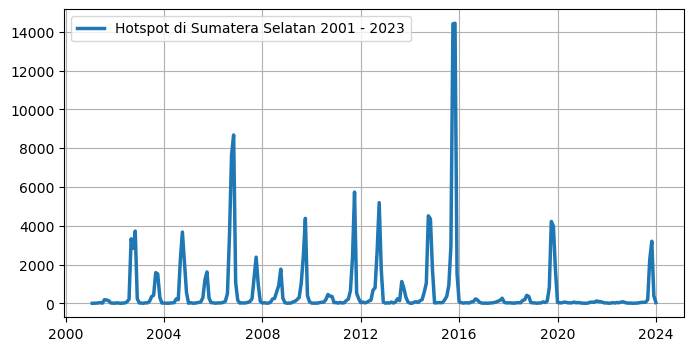

In [4]:
# hasil load dataset
lineplot1(dataset["acq_date"], dataset["hotspot"], "Hotspot di Sumatera Selatan 2001 - 2023")

### 2. Praproses Data

In [5]:
# proses normalisasi min-max
scaled = normalized(dataset, ["hotspot"])

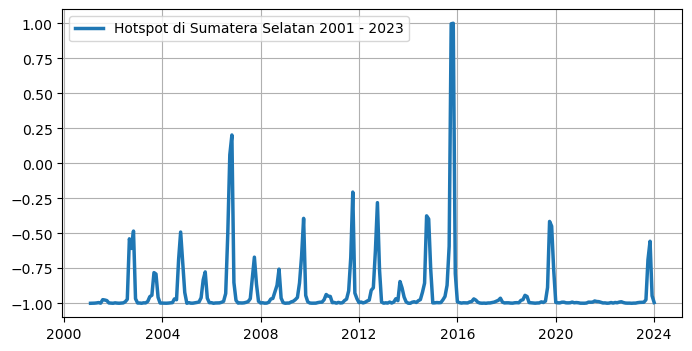

In [6]:
# hasil normalisasi min-max
lineplot1(dataset["acq_date"], np.array(scaled), "Hotspot di Sumatera Selatan 2001 - 2023")

### 3. Pembagian Data

In [7]:
# proses pembagian data
train_data, test_data = splitting(scaled)

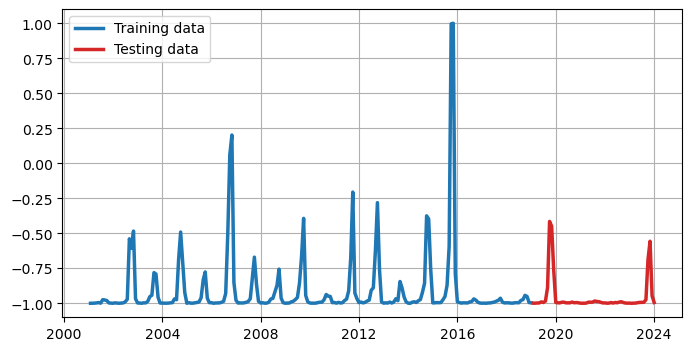

In [8]:
# hasil pembagian data
lineplot2(
  x1=dataset.iloc[0:len(train_data),0], y1=train_data, label1="Training data",
  x2=dataset.iloc[len(train_data):len(dataset),0], y2=test_data, label2="Testing data",
)

### 4. Supervised Learning

In [9]:
# function for supervised learning
x_train, y_train, x_test, y_test = results_supervised_learning(train_data, test_data)

In [10]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(215, 1, 1) (215,)


In [11]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 1) (59,)


### 5.1 Modeling SBi-LSTM

- SBi-LSTM

In [12]:
# call models LSTM
lstm_model = get_models(
  algorithm="SBi-LSTM",
  timestep=x_train.shape[1],
  activation="selu",
  dropout=0.25,
  optimizer="sgd"
)

In [13]:
# compile models
lstm_history, lstm_predictions = get_predictions(
  model=lstm_model,
  x_train=x_train, y_train=y_train,
  x_test=x_test, y_test=y_test,
  batch_size=8, epochs=1500
)

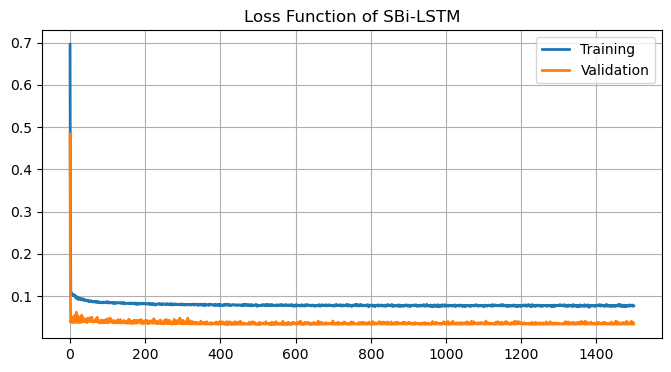

In [14]:
# show loss function
lineplot3(
  training=lstm_history.history['loss'],
  validation=lstm_history.history['val_loss'],
  title="Loss Function of SBi-LSTM"
)

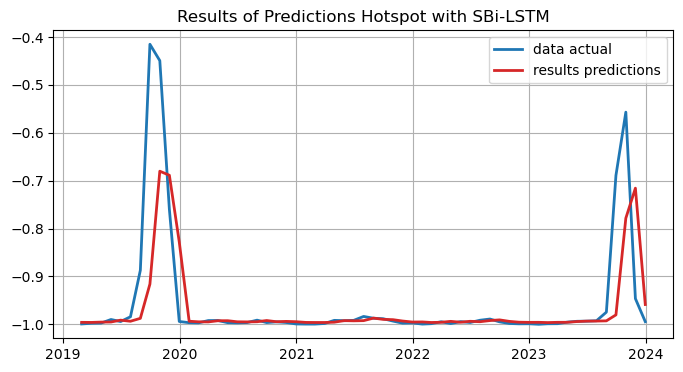

In [15]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=y_test,
  ypred=lstm_predictions,
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [16]:
# calculate eror
r, p_value, mae, rmse, mape = evaluate(y_test, lstm_predictions)

# show eror
print("Evaluate Models with : "+str("SBi-LSTM"))
print("-------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p_value))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with : SBi-LSTM
-------------------------------
R       : 0.6488
P-value : 0.0
MAE     : 0.034
RMSE    : 0.0953
MAPE    : 0.0568


- SBi-LSTM + XGBoost

In [17]:
# call models XGBoost
xgb_predictions = get_XGBoost(
  xtrue=x_test,
  ytrue=y_test,
  ypred=lstm_predictions
)

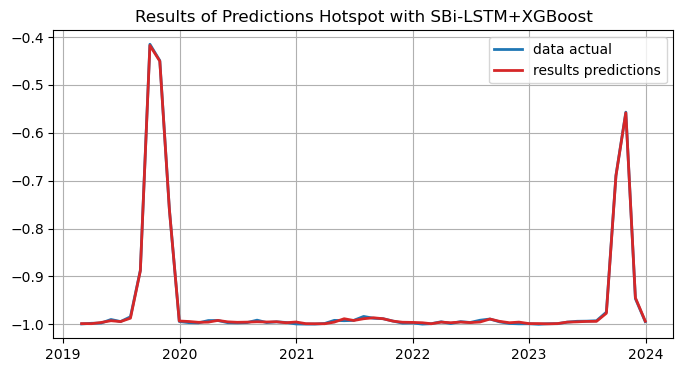

In [18]:
# show result predictions
lineplot4(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=y_test,
  ypred=xgb_predictions,
  title="Results of Predictions Hotspot with SBi-LSTM+XGBoost"
)

In [19]:
# calculate eror
r, p_value, mae, rmse, mape = evaluate(y_test, xgb_predictions)

# show eror
print("Evaluate Models with : "+str("SBi-LSTM+XGBoost"))
print("-------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p_value))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with : SBi-LSTM+XGBoost
-------------------------------
R       : 0.9999
P-value : 0.0
MAE     : 0.0014
RMSE    : 0.0018
MAPE    : 0.0015


### 6. Final Results

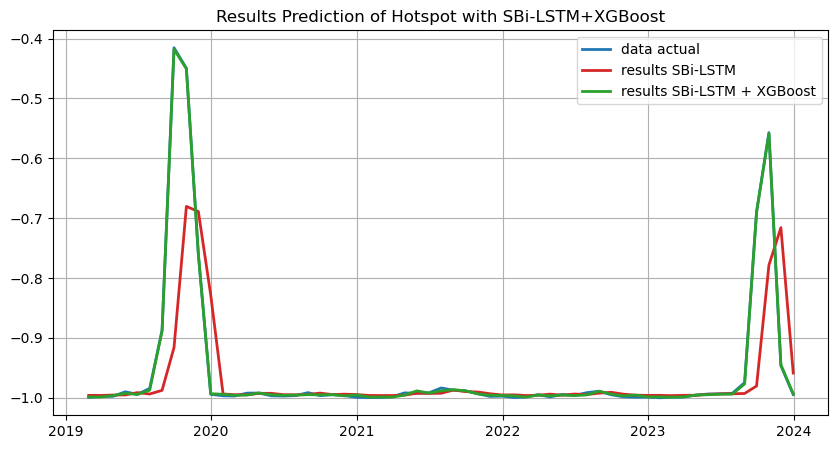

In [20]:
lineplot5(
  date=np.array(dataset["acq_date"].iloc[len(y_train)+2:]),
  ytrue=y_test,
  ypred1=lstm_predictions,
  label1="results SBi-LSTM",
  ypred2=xgb_predictions,
  label2="results SBi-LSTM + XGBoost",
  title="Results Prediction of Hotspot with SBi-LSTM+XGBoost"
)